In [20]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Reading the data
dataset = pd.read_csv('gemini_BTCUSD_1hr.csv', parse_dates = ['Date']).sort_values(by=['Unix Timestamp'])

print('Dataset shape: ', dataset.shape)
print(dataset.info())
dataset.head(2)

Dataset shape:  (36610, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36610 entries, 36609 to 0
Data columns (total 8 columns):
Unix Timestamp    36610 non-null int64
Date              36610 non-null datetime64[ns]
Symbol            36610 non-null object
Open              36610 non-null float64
High              36610 non-null float64
Low               36610 non-null float64
Close             36610 non-null float64
Volume            36610 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 2.5+ MB
None


,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
36609,1444309200,2015-10-08 13:00:00,BTCUSD,0.0,245.0,0.0,245.0,0.606654
36608,1444312800,2015-10-08 14:00:00,BTCUSD,245.0,245.0,244.5,245.0,4.453649


In [22]:
def plot_indicator(dataset,indicator):
    plt.figure(figsize=[20,5])
    plt.plot(dataset['Date'],dataset['Close'], label='Close')
    plt.plot(dataset['Date'],dataset[indicator], label=indicator)
    plt.grid()
    plt.legend()
    plt.show()

### Simple Moving Average

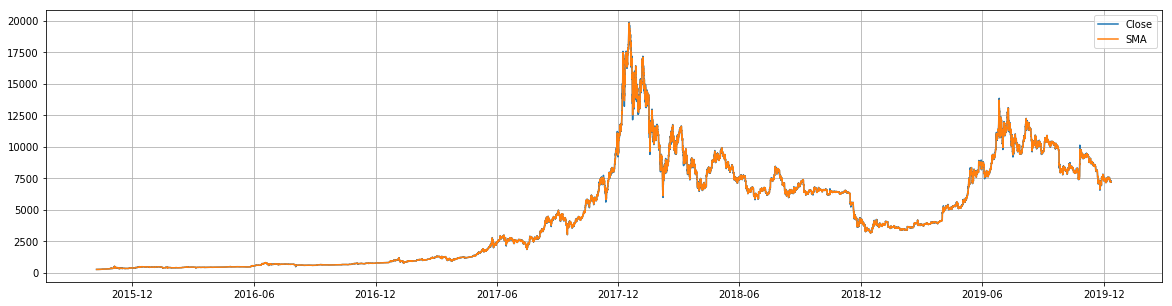

In [23]:
dataset['SMA'] = dataset['Close'].rolling(window=3).mean()

plot_indicator(dataset,'SMA')

### Cumulative Moving Average

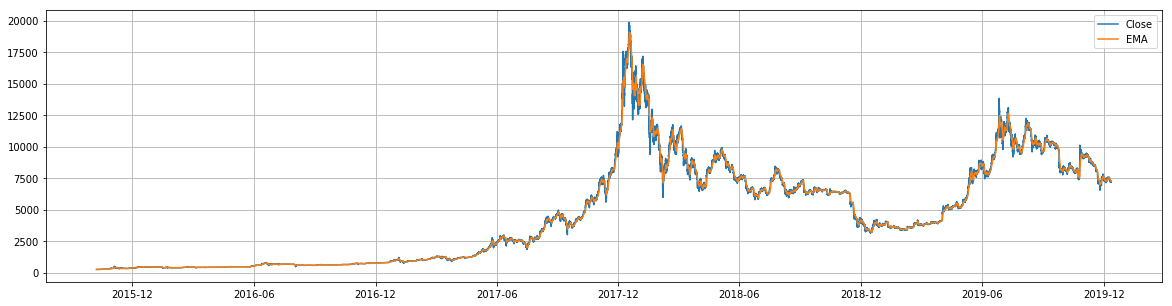

In [24]:
dataset['EMA'] = dataset['Close'].ewm(span=40,adjust=False).mean()

plot_indicator(dataset,'EMA')

### Momentum

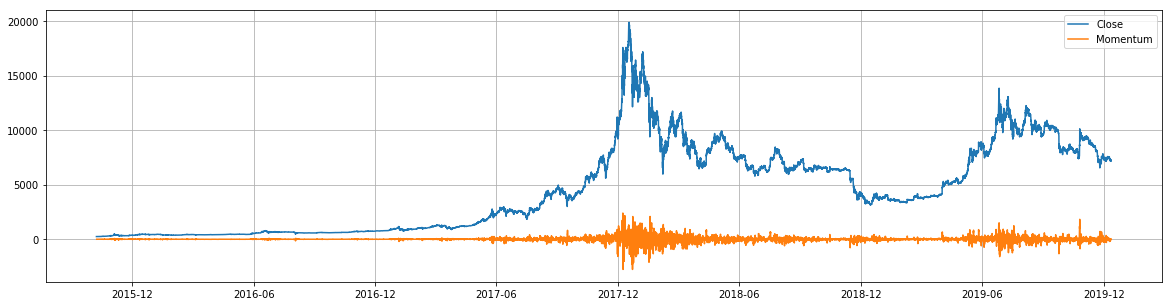

In [25]:
dataset['Momentum'] = dataset['Close'].diff(10)

plot_indicator(dataset,'Momentum')

### Rate of change

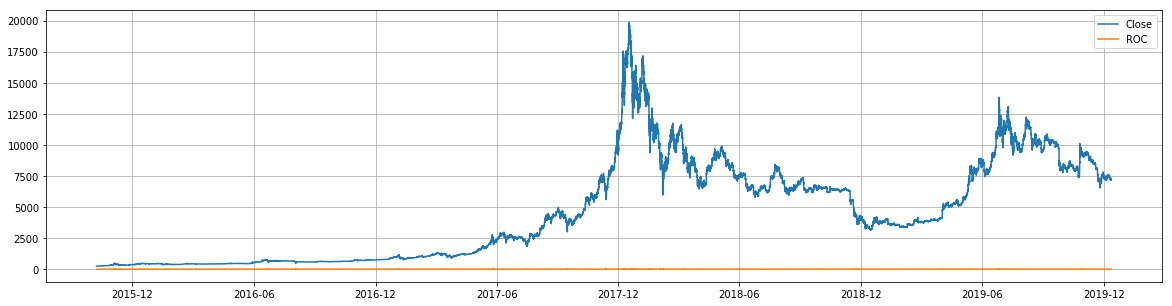

In [26]:
dataset['ROC'] = 100 * (dataset['Close'].diff(10 - 1) / dataset['Close'].shift(10 - 1))

plot_indicator(dataset,'ROC')

### Relative Strength Index

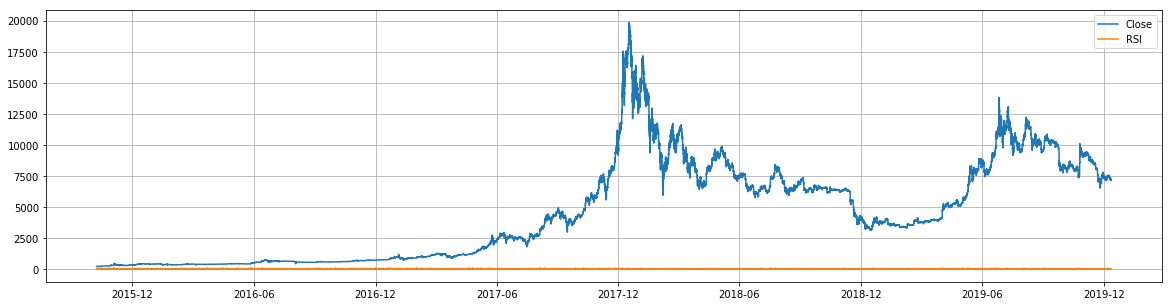

In [27]:
def RSI(df, column="Close", period=14):
    # wilder's RSI
 
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)   

    return df.join(rsi.to_frame('RSI'))

dataset = RSI(dataset)

plot_indicator(dataset,'RSI')

### On Balance Volume

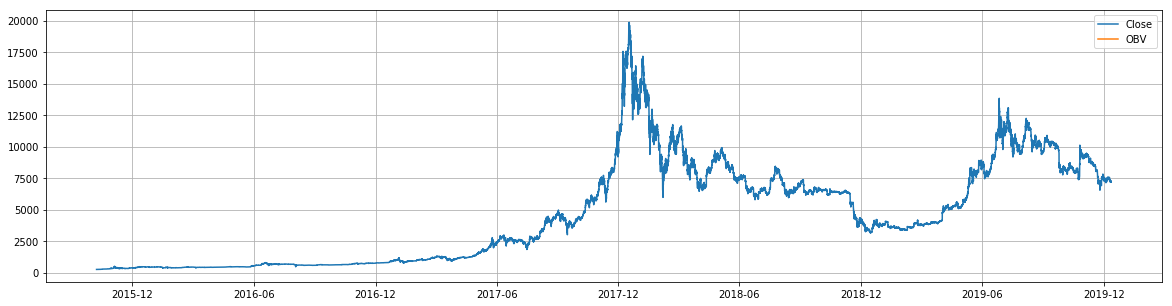

In [28]:
def on_balance_volume(df, n):
    """Calculate On-Balance Volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    while i < df.index[-1]:
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV')
    df = df.join(OBV_ma)
    return df

dataset = on_balance_volume(dataset,11)

plot_indicator(dataset,'OBV')

### Bollinger Band

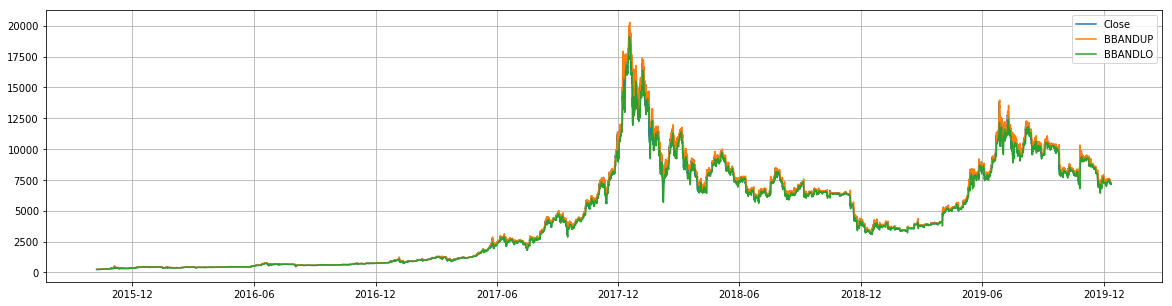

In [29]:
def BollingerBand(df, column="Close", period=20):

    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

dataset = BollingerBand(dataset)

bands = ['Close','BBANDUP','BBANDLO']
plt.figure(figsize=[20,5])

for indicator in bands:
    plt.plot(dataset['Date'],dataset[indicator], label=indicator)
    
plt.grid()
plt.legend()
plt.show()

### MACD

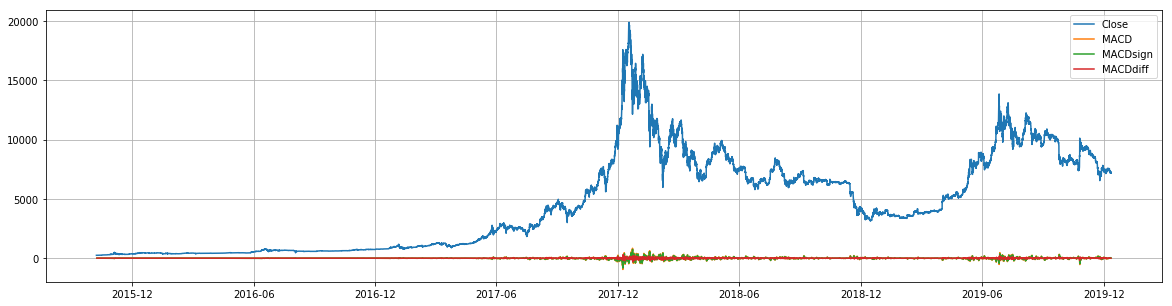

In [30]:
def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD')
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign')
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff')
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df

dataset = macd(dataset,26,12)

macds = ['Close','MACD','MACDsign','MACDdiff']
plt.figure(figsize=[20,5])

for indicator in macds:
    plt.plot(dataset['Date'],dataset[indicator], label=indicator)
    
plt.grid()
plt.legend()
plt.show()

### Accumulator Distribution

In [39]:
dataset.drop(columns=['Acc/Dist_ROC'])

def accumulation_distribution(df, n):
    """Calculate Accumulation/Distribution for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC')
    df = df.join(AD)
    return df

dataset = accumulation_distribution(dataset,15)

plot_indicator(dataset,'Acc/Dist_ROC')

ValueError: columns overlap but no suffix specified: Index(['Acc/Dist_ROC'], dtype='object')

In [32]:
dataset.to_csv('mock_stream_out.csv')